In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis,skew
import scipy as sp
from scipy import signal

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import mutual_info_classif

import yasa
from tqdm import tqdm
import xgboost as xgb

In [20]:
xtrain_eeg1 = pd.read_csv("train_eeg1.csv").drop("Id", axis = 1)
xtrain_eeg2 = pd.read_csv("train_eeg2.csv").drop("Id", axis = 1)
xtrain_emg = pd.read_csv("train_emg.csv").drop("Id", axis = 1)

ytrain = pd.read_csv("train_labels.csv").drop("Id", axis = 1)

xtest_eeg1 = pd.read_csv("test_eeg1.csv").drop("Id", axis = 1)
xtest_eeg2 = pd.read_csv("test_eeg2.csv").drop("Id", axis = 1)
xtest_emg = pd.read_csv("test_emg.csv").drop("Id", axis = 1)

In [4]:
print(xtrain_eeg1.shape)
print(xtrain_eeg2.shape)
print(xtrain_emg.shape)
print(xtest_eeg1.shape)
print(xtest_eeg2.shape)
print(xtest_emg.shape)
print(ytrain.shape)

(64800, 512)
(64800, 512)
(64800, 512)
(43200, 512)
(43200, 512)
(43200, 512)
(64800, 1)


In [5]:
xtrain_eeg1.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x503,x504,x505,x506,x507,x508,x509,x510,x511,x512
0,0.000400,0.000470,0.000067,-0.00016,-0.000003,0.00031,0.000360,0.00019,-0.000072,-0.00007,...,-0.000086,0.000033,-0.000046,-0.000270,-0.000390,-0.00034,-0.00032,-0.00021,0.000042,0.000053
1,0.000067,0.000095,0.000270,0.00028,0.000250,0.00012,0.000094,-0.00034,-0.000960,-0.00120,...,0.000046,0.000300,0.000630,0.000710,0.000520,0.00041,0.00066,0.00088,0.000770,0.000410
2,0.000160,-0.000210,-0.000840,-0.00120,-0.001200,-0.00140,-0.001400,-0.00091,-0.000600,-0.00027,...,-0.000680,-0.000880,-0.001000,-0.000770,-0.000680,-0.00073,-0.00073,-0.00062,-0.000550,-0.000540
3,-0.000140,0.000260,0.000390,0.00043,0.000280,0.00023,0.000390,0.00022,0.000150,0.00022,...,0.000720,0.000760,0.000380,0.000052,-0.000260,-0.00058,-0.00075,-0.00110,-0.001200,-0.001200
4,-0.001100,-0.000790,-0.000081,0.00014,0.000200,-0.00014,-0.000430,-0.00053,-0.000580,-0.00041,...,0.000290,0.000600,0.000670,0.000190,-0.000055,-0.00016,-0.00023,-0.00023,-0.000330,-0.000810


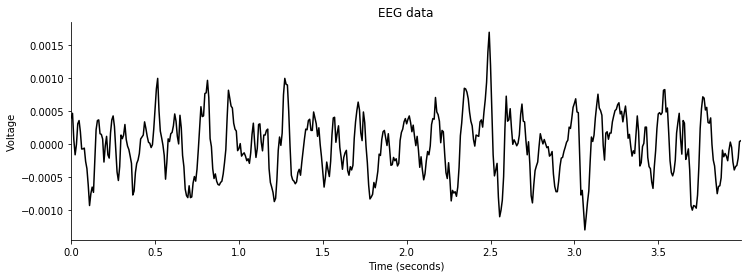

In [6]:
signal = xtrain_eeg1.iloc[0,:].values
# signal = xtrain_eeg1.values.ravel()

# Define sampling frequency and time vector
sf = 128.
time = np.arange(signal.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, signal, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('EEG data')
sns.despine()

In [35]:
# Define function to extract features from eeg signal
# Note that yasa's bandpower function limits the row length to the amount of columns divided by 2
# Therefore, iterate in for loop 100 rows at a time

def extract_features_eeg(eeg_signal, frequency = 128):
    for i in (np.arange(eeg_signal.shape[0] / 100) + 1):
        if i == 1:
            df = yasa.bandpower(eeg_signal.iloc[0:int(100*i),:].values, sf=frequency)
        else:
            df = df.append(yasa.bandpower(eeg_signal.iloc[int(100*(i-1)):int(100*i),:].values, sf=frequency))
    
    df = df.set_index(np.arange(eeg_signal.shape[0]))
    df = df.drop(columns = ["FreqRes","Relative"], axis = 1)
    return df

def process_emg(emg_signal, fs = 128):
    # First remove offset by mean
    means = emg_signal.apply(np.mean, axis = 1)
    for i in np.arange(len(emg_signal)):
        emg_signal.iloc[i,:] = emg_signal.iloc[i,:] - means[i]
    
    # Second, filter signal with high and low pass filter settings
    high = 2.56/(fs/2) # these values can be changed
    low = 57.6/(fs/2) # these values can be changed
    b, a = sp.signal.butter(4, [high,low], btype='bandpass')
    for i in np.arange(len(emg_signal)):
        emg_signal.iloc[i,:] = sp.signal.filtfilt(b, a, emg_signal.iloc[i,:].values)
    
    # Third, rectify signal (absolute value)
    ## TRY REMOVING 
    emg_signal = emg_signal.abs()
    
    return emg_signal
    

def simple_statistics(sig, fs=128):
    """ TESTED for (nxd) matrix input """
    # Check if it is not a 1d array
    if (len(sig.shape) > 1) and (sig.shape[1]!=1):
        return np.array([np.mean(sig, axis=1), np.median(sig, axis=1),
                    np.std(sig, axis=1), np.max(sig, axis=1),
                    np.min(sig, axis=1), kurtosis(sig, axis=1),
                    skew(sig, axis=1)]).T
    else:
        print("Not Tested with this input!")
        return np.array([np.mean(sig), np.median(sig), np.std(sig),
                np.max(sig), np.min(sig), float(kurtosis(sig)),
                float(skew(sig))])

def vectorized_adv_stat(signal, fs=128):
    K_boundary = 10         # to be tuned
    t_fisher = 12          # to be tuned
    d_fisher = 40          # to be tuned
    features_num = 11
    threshold =  0.0009
    advanced_stats = np.zeros((signal.shape[0],features_num))
    print("Gathering advanced statistics...")
    feat_array = np.array([
                           pfd(signal),
                           hfd(signal, K_boundary),
                           np.sum((np.power(np.abs(signal),(-0.3)) > 20), axis=1),
                           np.sum((np.abs(signal)) > threshold, axis=1),
                           np.std(np.power(np.abs(signal),(0.05)), axis=1),
                           np.sqrt(np.mean(np.power(np.diff(signal, axis=1), 2), axis=1)),
                           np.mean(np.abs(np.diff(signal, axis=1)), axis=1),
                           np.mean(np.power(signal, 5), axis=1),
                           np.sum(np.power(signal, 2), axis=1)
                           ]).T
    return feat_array

def pfd(X):
    return pfd(X.values)

def pfd(X):
    """VECTORIZED!!! TESTED, matches the 1d time series output. Now accepts (nxd) matrices as input
    Compute Petrosian Fractal Dimension of a time series from either two
    cases below:
        1. X, the time series of type list (default)
        2. D, the first order differential sequence of X (if D is provided,
           recommended to speed up)
    In case 1, D is computed using Numpy's difference function.
    To speed up, it is recommended to compute D before calling this function
    because D may also be used by other functions whereas computing it here
    again will slow down.
    """
    n = X.shape[1]
    diff = np.diff(X, axis=1)
    N_delta = np.sum(diff[:, 1:-1] * diff[:, 0:-2] < 0, axis=1)
    return np.log10(n) / (np.log10(n) + np.log10(n / (n + 0.4 * N_delta)))

def hfd(X, Kmax):
    return hfd(X.values, Kmax)

def hfd(X, Kmax):
    """ VECTORIZED!!! TESTED: Matches the for loop output. Can test easily comparing
    to the pyeeg.hfd() function. X now a (nxd) matrix.
    Compute Higuchi Fractal Dimension of a time series X. kmax
     is an HFD parameter
    """
    L = []
    x = []
    N = X.shape[1]
    for k in tqdm(range(1, Kmax)):
        # Lk = np.empty(shape=[0, ])
        Lk = np.empty(shape=[X.shape[0], 1])
        for m in range(0, k):
            Lmk = 0
            for i in range(1, int(np.floor((N - m) / k))):
                Lmk += np.abs(X[:, m + i * k] - X[:, m + i * k - k])
            Lmk = Lmk * (N - 1) / np.floor((N - m) / float(k)) / k
            Lmk = np.reshape(Lmk, (Lmk.shape[0], 1))
            Lk = np.hstack((Lk, Lmk))

        # Remove that first placeholder column of zeros in Lk:
        Lk = Lk[:, 1:]
        L.append(np.log(np.mean(Lk, axis=1)))
        x.append([np.log(float(1) / k), 1]) # Fix this!!!

    (p, _, _, _) = np.linalg.lstsq(x, L)
    return p[0]

In [36]:
xtrain1 = extract_features_eeg(xtrain_eeg1, 128)
xtrain2 = extract_features_eeg(xtrain_eeg2, 128)
xtrain2 = xtrain2.rename(columns = {"Delta": "Delta2", "Theta": "Theta2", "Alpha": "Alpha2",
                         "Beta": "Beta2", "Gamma": "Gamma2"})
xtrain_eeg = xtrain1.join(xtrain2)
xtrain_eeg.head()

,Delta,Theta,Alpha,Beta,Gamma,Delta2,Theta2,Alpha2,Beta2,Gamma2
0,0.167779,0.589067,0.142509,0.084657,0.015988,0.145824,0.627337,0.140520,0.068544,0.017776
1,0.261716,0.384270,0.197637,0.141042,0.015335,0.274465,0.360708,0.230005,0.116119,0.018703
2,0.294706,0.191459,0.337027,0.158918,0.017890,0.360250,0.224307,0.271524,0.124966,0.018952
3,0.168293,0.581209,0.130216,0.105173,0.015109,0.129359,0.648551,0.135427,0.074995,0.011668
4,0.239408,0.542883,0.131650,0.076140,0.009920,0.118469,0.635031,0.127040,0.107246,0.012214


In [37]:
stats = simple_statistics(xtrain_eeg1)
stats1 = pd.DataFrame({"Mean": stats[:,0], "Median": stats[:,1], "Std": stats[:,2],
             "Max": stats[:,3], "Min": stats[:,4], "Kurtosis": stats[:,5], "Skew": stats[:,6]})
xtrain_eeg = xtrain_eeg.join(stats1)
stats = simple_statistics(xtrain_eeg2)
stats2 = pd.DataFrame({"Mean2": stats[:,0], "Median2": stats[:,1], "Std2": stats[:,2],
             "Max2": stats[:,3], "Min2": stats[:,4], "Kurtosis2": stats[:,5], "Skew2": stats[:,6]})
xtrain_eeg = xtrain_eeg.join(stats2)

#xtrain_emg = process_emg(xtrain_emg)

stats = simple_statistics(xtrain_emg)
stats3 = pd.DataFrame({"Mean_emg": stats[:,0], "Median_emg": stats[:,1], "Std_emg": stats[:,2],
             "Max_emg": stats[:,3], "Min_emg": stats[:,4], "Kurtosis_emg": stats[:,5], "Skew_emg": stats[:,6]})
xtrain_eeg = xtrain_eeg.join(stats3)

stats = vectorized_adv_stat(xtrain_emg.values)
stats4 = pd.DataFrame({"x1": stats[:,0], "x2": stats[:,1], "x3": stats[:,2],
             "x4": stats[:,3], "x5": stats[:,4], "x6": stats[:,5], "x7": stats[:,6],
                "x8": stats[:,7], "x9": stats[:,8]})
xtrain_eeg = xtrain_eeg.join(stats4)

xtrain_eeg.head()

Gathering advanced statistics...


100%|██████████| 9/9 [00:00<00:00,  9.58it/s]
/Users/andreasopedaleriksson/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/andreasopedaleriksson/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in power


,Delta,Theta,Alpha,Beta,Gamma,Delta2,Theta2,Alpha2,Beta2,Gamma2,...,Skew_emg,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.167779,0.589067,0.142509,0.084657,0.015988,0.145824,0.627337,0.140520,0.068544,0.017776,...,-1.815205,1.034824,0.945445,502.0,0.0,0.041635,0.000013,0.000008,-1.534967e-23,1.141335e-07
1,0.261716,0.384270,0.197637,0.141042,0.015335,0.274465,0.360708,0.230005,0.116119,0.018703,...,-2.176539,1.035475,0.959493,504.0,0.0,0.048162,0.000011,0.000007,-1.068713e-23,9.859970e-08
2,0.294706,0.191459,0.337027,0.158918,0.017890,0.360250,0.224307,0.271524,0.124966,0.018952,...,-1.166946,1.034497,0.933330,509.0,0.0,0.040260,0.000010,0.000007,-5.078667e-24,8.570733e-08
3,0.168293,0.581209,0.130216,0.105173,0.015109,0.129359,0.648551,0.135427,0.074995,0.011668,...,-2.216652,1.036557,0.937956,505.0,0.0,0.040202,0.000011,0.000007,-1.047347e-23,1.019762e-07
4,0.239408,0.542883,0.131650,0.076140,0.009920,0.118469,0.635031,0.127040,0.107246,0.012214,...,-2.203634,1.033407,0.940074,507.0,0.0,0.040239,0.000010,0.000006,-7.752188e-24,8.427712e-08


In [42]:
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain_eeg)
xtrain_scaled = pd.DataFrame(xtrain_scaled, columns = xtrain_eeg.columns)
xtrain_scaled.head()

,Delta,Theta,Alpha,Beta,Gamma,Delta2,Theta2,Alpha2,Beta2,Gamma2,...,Skew_emg,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,-1.011187,2.268461,-0.420041,-1.136340,-0.688844,-1.306728,2.510711,-0.421807,-1.406019,-0.501901,...,-1.398622,-0.494115,0.313840,1.115484,-0.124582,0.114297,-0.815478,-0.829049,-0.007058,-0.203295
1,-0.353931,0.538933,0.035142,-0.043393,-0.719630,-0.352300,0.275443,0.365257,-0.385367,-0.454730,...,-1.694978,-0.294872,0.402868,1.129789,-0.124582,0.724086,-0.829865,-0.843736,-0.007058,-0.203768
2,-0.123110,-1.089365,1.186058,0.303118,-0.599066,0.284165,-0.868064,0.730441,-0.195581,-0.442027,...,-0.866939,-0.593926,0.237069,1.165554,-0.124582,-0.014148,-0.843336,-0.853970,-0.007058,-0.204161
3,-1.007590,2.202099,-0.521540,-0.738669,-0.730314,-1.428885,2.688560,-0.466600,-1.267628,-0.812704,...,-1.727877,0.036082,0.266380,1.136942,-0.124582,-0.019604,-0.837730,-0.851165,-0.007058,-0.203665
4,-0.510020,1.878431,-0.509704,-1.301434,-0.975195,-1.509683,2.575216,-0.540365,-0.575737,-0.784925,...,-1.717200,-0.927550,0.279802,1.151248,-0.124582,-0.016146,-0.841858,-0.856954,-0.007058,-0.204205


In [43]:
corr_df = ytrain.join(xtrain_scaled)
corr_df.corr()

,y,Delta,Theta,Alpha,Beta,Gamma,Delta2,Theta2,Alpha2,Beta2,...,Skew_emg,x1,x2,x3,x4,x5,x6,x7,x8,x9
y,1.000000,0.237751,0.199109,-0.231032,-0.317460,-0.622888,0.145964,0.243162,-0.188634,-0.317625,...,-0.136050,-0.345841,-0.244870,0.682687,-0.107671,-0.166074,-0.682439,-0.671854,-0.004103,-0.167770
Delta,0.237751,1.000000,-0.401326,-0.526869,-0.421306,-0.465146,0.833979,-0.267251,-0.476656,-0.380655,...,-0.050828,-0.102096,-0.070040,0.375448,-0.063770,0.126314,-0.362203,-0.364426,-0.004738,-0.095444
Theta,0.199109,-0.401326,1.000000,-0.454961,-0.120266,0.011905,-0.339174,0.825450,-0.433043,-0.079128,...,-0.020549,-0.066416,-0.056101,0.075205,-0.000753,-0.076689,-0.059121,-0.067041,-0.000167,-0.009251
Alpha,-0.231032,-0.526869,-0.454961,1.000000,0.098135,0.141579,-0.459464,-0.461018,0.929158,0.158225,...,0.078632,0.095525,0.058331,-0.320558,0.026960,-0.061224,0.266313,0.278435,0.004550,0.058152
Beta,-0.317460,-0.421306,-0.120266,0.098135,1.000000,0.518205,-0.310798,-0.071866,0.089228,0.694898,...,-0.024971,0.100771,0.099809,-0.227107,0.061542,-0.044534,0.258455,0.258257,0.002975,0.077809
Gamma,-0.622888,-0.465146,0.011905,0.141579,0.518205,1.000000,-0.346971,-0.000216,0.107003,0.413496,...,0.069029,0.268454,0.209522,-0.567523,0.130408,0.034931,0.622030,0.612482,-0.000351,0.173651
Delta2,0.145964,0.833979,-0.339174,-0.459464,-0.310798,-0.346971,1.000000,-0.420585,-0.511523,-0.410763,...,-0.025211,-0.140893,-0.129974,0.251577,-0.053139,0.079973,-0.286949,-0.290065,-0.002057,-0.076955
Theta2,0.243162,-0.267251,0.825450,-0.461018,-0.071866,-0.000216,-0.420585,1.000000,-0.465863,-0.166457,...,-0.080298,0.005538,0.045501,0.182887,0.011053,-0.030901,-0.084675,-0.093021,-0.004548,-0.005776
Alpha2,-0.188634,-0.476656,-0.433043,0.929158,0.089228,0.107003,-0.511523,-0.465863,1.000000,0.164288,...,0.066171,0.104476,0.077530,-0.265490,0.022441,-0.045099,0.233797,0.246246,0.002985,0.048313
Beta2,-0.317625,-0.380655,-0.079128,0.158225,0.694898,0.413496,-0.410763,-0.166457,0.164288,1.000000,...,0.064247,0.036342,-0.000308,-0.290108,0.028885,-0.037331,0.228758,0.231840,0.005675,0.054518


In [47]:
mu_info = mutual_info_classif(xtrain_eeg.values, ytrain.values.ravel())
mu_info

array([1.74165545e-01, 7.99237935e-02, 7.15225315e-02, 8.10671827e-02,
       4.58329582e-01, 1.39871628e-01, 8.30667569e-02, 5.43084588e-02,
       7.89312636e-02, 4.82115185e-01, 8.73990898e-03, 3.76429737e-02,
       4.56881338e-01, 3.05479095e-01, 1.80246811e-01, 4.26501134e-02,
       4.88062371e-02, 1.37189286e-02, 4.93786307e-02, 2.57993109e-01,
       2.39000068e-01, 8.33751164e-02, 5.63293350e-02, 7.84169313e-02,
       2.18036879e-01, 1.60975223e-01, 4.70600841e-01, 5.15050578e-01,
       5.05110400e-01, 1.64293936e-01, 6.30753976e-02, 1.16970776e-01,
       1.66043079e-01, 3.45643682e-01, 1.07820896e-01, 1.44400152e-01,
       5.70936519e-01, 5.69448147e-01, 1.07867469e-04, 4.64127459e-01])

In [55]:
pd.Series(mu_info, index = xtrain_eeg.columns).sort_values(ascending = True)

x8              0.000108
Mean            0.008740
Mean2           0.013719
Median          0.037643
Kurtosis        0.042650
Skew            0.048806
Median2         0.049379
Alpha2          0.054308
Kurtosis2       0.056329
Skew_emg        0.063075
Alpha           0.071523
Skew2           0.078417
Beta2           0.078931
Theta           0.079924
Beta            0.081067
Theta2          0.083067
Min2            0.083375
x4              0.107821
x1              0.116971
Delta2          0.139872
x5              0.144400
Median_emg      0.160975
Kurtosis_emg    0.164294
x2              0.166043
Delta           0.174166
Min             0.180247
Mean_emg        0.218037
Max2            0.239000
Std2            0.257993
Max             0.305479
x3              0.345644
Std             0.456881
Gamma           0.458330
x9              0.464127
Std_emg         0.470601
Gamma2          0.482115
Min_emg         0.505110
Max_emg         0.515051
x7              0.569448
x6              0.570937


In [31]:
## SVC APPROACH -- GRID-SEARCH CV
'''
steps = [("scaler", StandardScaler()), ("classifier", SVC())]
pipeline = Pipeline(steps = steps)

parameters = {"classifier__kernel": ["rbf"],
              "classifier__gamma": ["auto"],
              "classifier__C": [0.1, 0.2, 0.3, 0.4, 0.5],  
              "classifier__class_weight": ["balanced"],
              "classifier__degree": [1,3,5]
             }

grid = GridSearchCV(pipeline, parameters, cv = 3, scoring = 'balanced_accuracy', verbose = 3)

grid.fit(xtrain_eeg.values, ytrain.values.ravel())
print(grid.best_score_)
print(grid.best_params_)
'''

## XGB APPROACH -- GRID-SEARCH CV

steps = [("scaler", StandardScaler()), ("classifier", xgb.XGBClassifier())]
pipeline = Pipeline(steps = steps)

parameters = {"classifier__max_depth": [5,10,15,20],
              "classifier__n_estimators": [200],
              "classifier__learning_rate": [0.05,0.1,0.15,0.2],
              "classifier__max_features": [20,40,60]
             }

grid = GridSearchCV(pipeline, parameters, cv = 3, scoring = 'balanced_accuracy', verbose = 3)

grid.fit(xtrain_eeg.values, ytrain.values.ravel())
print(grid.best_score_)
print(grid.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] classifier__learning_rate=0.05, classifier__max_depth=5, classifier__max_features=20, classifier__n_estimators=200 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__learning_rate=0.05, classifier__max_depth=5, classifier__max_features=20, classifier__n_estimators=200, score=0.813, total= 2.4min
[CV] classifier__learning_rate=0.05, classifier__max_depth=5, classifier__max_features=20, classifier__n_estimators=200 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


[CV]  classifier__learning_rate=0.05, classifier__max_depth=5, classifier__max_features=20, classifier__n_estimators=200, score=0.925, total= 2.2min
[CV] classifier__learning_rate=0.05, classifier__max_depth=5, classifier__max_features=20, classifier__n_estimators=200 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.6min remaining:    0.0s


[CV]  classifier__learning_rate=0.05, classifier__max_depth=5, classifier__max_features=20, classifier__n_estimators=200, score=0.757, total= 2.3min
[CV] classifier__learning_rate=0.05, classifier__max_depth=5, classifier__max_features=40, classifier__n_estimators=200 
[CV]  classifier__learning_rate=0.05, classifier__max_depth=5, classifier__max_features=40, classifier__n_estimators=200, score=0.813, total= 2.2min
[CV] classifier__learning_rate=0.05, classifier__max_depth=5, classifier__max_features=40, classifier__n_estimators=200 
[CV]  classifier__learning_rate=0.05, classifier__max_depth=5, classifier__max_features=40, classifier__n_estimators=200, score=0.925, total= 2.4min
[CV] classifier__learning_rate=0.05, classifier__max_depth=5, classifier__max_features=40, classifier__n_estimators=200 
[CV]  classifier__learning_rate=0.05, classifier__max_depth=5, classifier__max_features=40, classifier__n_estimators=200, score=0.757, total= 2.2min
[CV] classifier__learning_rate=0.05, clas

[CV]  classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=60, classifier__n_estimators=200, score=0.807, total= 4.7min
[CV] classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=60, classifier__n_estimators=200 
[CV]  classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=60, classifier__n_estimators=200, score=0.929, total= 5.2min
[CV] classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=60, classifier__n_estimators=200 
[CV]  classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=60, classifier__n_estimators=200, score=0.765, total= 5.0min
[CV] classifier__learning_rate=0.1, classifier__max_depth=5, classifier__max_features=20, classifier__n_estimators=200 
[CV]  classifier__learning_rate=0.1, classifier__max_depth=5, classifier__max_features=20, classifier__n_estimators=200, score=0.803, total= 2.0min
[CV] classifier__learning_rate=0.1, cl

[CV]  classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=20, classifier__n_estimators=200, score=0.930, total= 4.5min
[CV] classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=20, classifier__n_estimators=200 
[CV]  classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=20, classifier__n_estimators=200, score=0.765, total= 4.3min
[CV] classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=40, classifier__n_estimators=200 
[CV]  classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=40, classifier__n_estimators=200, score=0.807, total= 4.0min
[CV] classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=40, classifier__n_estimators=200 
[CV]  classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=40, classifier__n_estimators=200, score=0.930, total= 4.5min
[CV] classifier__learning_rate=0.1, class

[CV]  classifier__learning_rate=0.15, classifier__max_depth=15, classifier__max_features=40, classifier__n_estimators=200, score=0.767, total= 3.8min
[CV] classifier__learning_rate=0.15, classifier__max_depth=15, classifier__max_features=60, classifier__n_estimators=200 
[CV]  classifier__learning_rate=0.15, classifier__max_depth=15, classifier__max_features=60, classifier__n_estimators=200, score=0.807, total= 3.6min
[CV] classifier__learning_rate=0.15, classifier__max_depth=15, classifier__max_features=60, classifier__n_estimators=200 
[CV]  classifier__learning_rate=0.15, classifier__max_depth=15, classifier__max_features=60, classifier__n_estimators=200, score=0.930, total= 4.0min
[CV] classifier__learning_rate=0.15, classifier__max_depth=15, classifier__max_features=60, classifier__n_estimators=200 
[CV]  classifier__learning_rate=0.15, classifier__max_depth=15, classifier__max_features=60, classifier__n_estimators=200, score=0.767, total= 3.8min
[CV] classifier__learning_rate=0.1

[CV]  classifier__learning_rate=0.2, classifier__max_depth=15, classifier__max_features=20, classifier__n_estimators=200, score=0.806, total= 3.4min
[CV] classifier__learning_rate=0.2, classifier__max_depth=15, classifier__max_features=20, classifier__n_estimators=200 
[CV]  classifier__learning_rate=0.2, classifier__max_depth=15, classifier__max_features=20, classifier__n_estimators=200, score=0.931, total= 3.7min
[CV] classifier__learning_rate=0.2, classifier__max_depth=15, classifier__max_features=20, classifier__n_estimators=200 
[CV]  classifier__learning_rate=0.2, classifier__max_depth=15, classifier__max_features=20, classifier__n_estimators=200, score=0.770, total= 3.6min
[CV] classifier__learning_rate=0.2, classifier__max_depth=15, classifier__max_features=40, classifier__n_estimators=200 
[CV]  classifier__learning_rate=0.2, classifier__max_depth=15, classifier__max_features=40, classifier__n_estimators=200, score=0.806, total= 3.3min
[CV] classifier__learning_rate=0.2, class

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 497.7min finished


0.8362331538349184
{'classifier__learning_rate': 0.2, 'classifier__max_depth': 10, 'classifier__max_features': 20, 'classifier__n_estimators': 200}


Note: Compared performance with and without summary statistics. Marginally better with, 0.8596 vs 0.8541  
Update: Even better with summary statistics of emg added: 0.9066

With advanced stats  
EMG processing no absolute value: 0.90758 
EMG processing absolute value: 0.89972
EMG no processing: 0.90535

In [24]:
from biosppy.signals import emg

In [28]:
emg.emg(signal = xtrain_emg.iloc[0,:], sampling_rate = 128, show = True)

ValueError: Digital filter critical frequencies must be 0 < Wn < 1